# Práctica 1: Algoritmo SOM de Kohonen en una dimension

Los mapas auto-organizativos originalmente propuestos por Teuvo Kohonen se implementaron sobre redes bidimensionales. De hecho, son los mapas más utilizados porque esta dimensión permite una visualización adecuada de los clusters con un esfuerzo computacional razonable.

No obstante, los fundamentos del algoritmo de Kohonen se pueden comprender de una manera si cabe más inmediata si las neuronas forman una red unidimensional. En esta primera sección vamos a aplicar un SOM unidimesional para clasificar una colección de vectores binarios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## _Definición de los datos_

Definimos una colección de $n_i$ vectores de entrada (instancias) de dimensión $n_d$ formados por elementos en el conjunto $\{0,1\}$. Un parámetro que podemos dejar libre es la proporción de cada uno de los dígitos. Usaremos una proporción de 5 a 1.

In [2]:
elementos = [0,1]
proporcion = [5/6,1/6]

np.random.choice(elementos,size=10,replace=True,p=proporcion)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [3]:
# generamos datos iniciales

nd = 10
ni = 1000
columnas = [i for i in np.arange(nd)]
datosIniciales = pd.DataFrame(0,columns = columnas,index=np.arange(ni))
for i in np.arange(ni):
    datosIniciales.loc[i] = np.random.choice(elementos,size=10,replace=True,p=proporcion)
datosIniciales

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,1,1,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,0,0,1
998,0,0,0,0,0,0,1,1,1,0


In [4]:
# sumamos por filas
datosIniciales.sum(axis=1)

0      1
1      4
2      0
3      0
4      1
      ..
995    3
996    1
997    1
998    3
999    1
Length: 1000, dtype: int64

In [5]:
datosIniciales.sum(axis=1).mean()

1.688

In [6]:
datosIniciales.sum().sum(),datosIniciales.sum().sum()/(datosIniciales.shape[0]*datosIniciales.shape[1])

(1688, 0.1688)

In [7]:
1/6

0.16666666666666666

In [8]:
datosIniciales.mean(),datosIniciales.std()

(0    0.173
 1    0.162
 2    0.161
 3    0.183
 4    0.174
 5    0.164
 6    0.155
 7    0.171
 8    0.172
 9    0.173
 dtype: float64,
 0    0.378437
 1    0.368635
 2    0.367715
 3    0.386860
 4    0.379299
 5    0.370461
 6    0.362086
 7    0.376697
 8    0.377569
 9    0.378437
 dtype: float64)

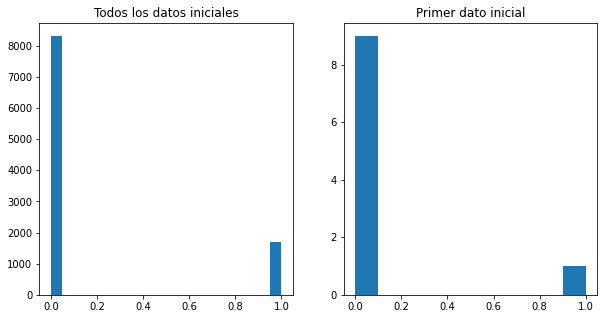

In [9]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
allDataVector = datosIniciales.to_numpy().ravel()
ax[0].hist(allDataVector,bins=20)
ax[0].set_title('Todos los datos iniciales')
ax[1].hist(datosIniciales.loc[0])
ax[1].set_title('Primer dato inicial')
plt.show()

<AxesSubplot:>

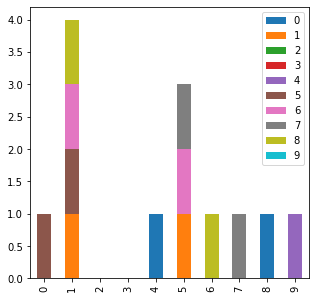

In [10]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(5,5))
datosIniciales[:10].plot.bar(stacked=True,ax=ax)

In [11]:
datosIniciales[:10]

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,1,0,0
6,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,1,0,0
8,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:>

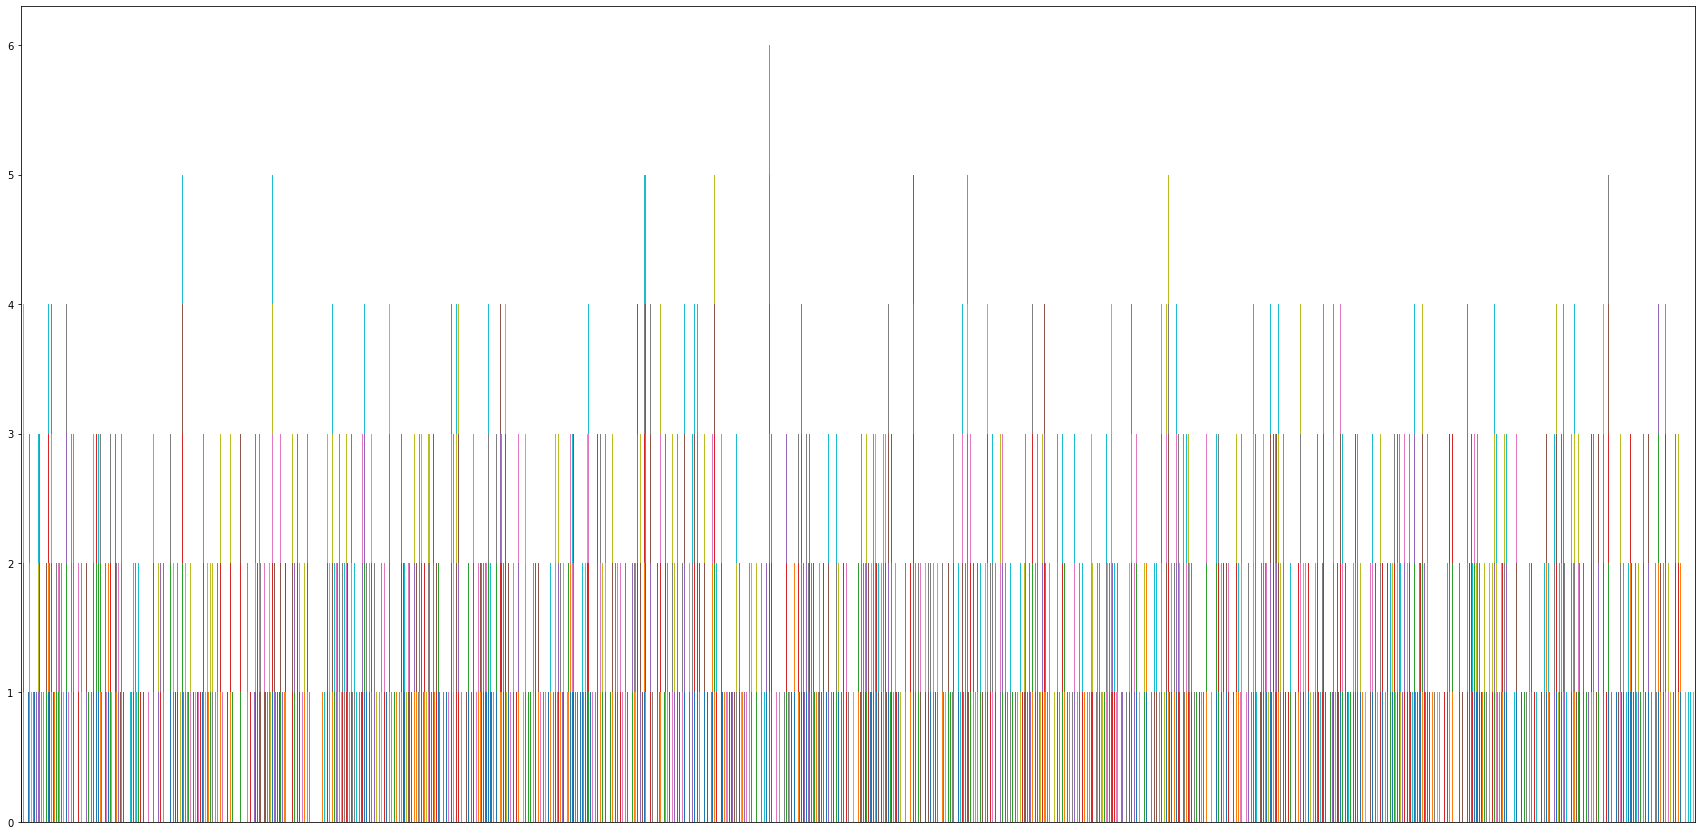

In [12]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(30,15))
datosIniciales.plot.bar(stacked=True,ax=ax,legend=False,xticks=[])

In [13]:
datosIniciales.sum(axis=1).max()

6

In [14]:
datosIniciales.sum(axis=1).argmax()

447

### Medias y varianzas de los datos

* Por atributo
* Por dato

Text(0.5, 0.98, 'Medias y desviaciones típicas')

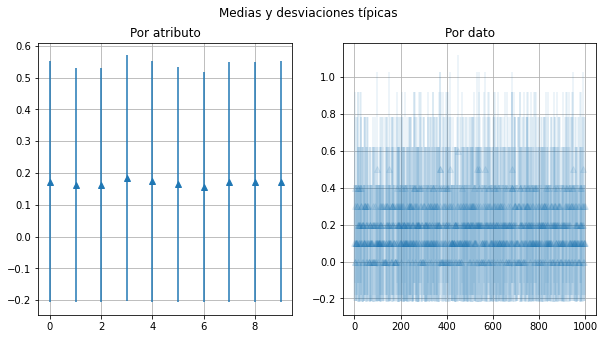

In [15]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
x=np.arange(nd)
ax[0].errorbar(x,datosIniciales.mean(),datosIniciales.std(),linestyle='None', marker='^')
ax[0].grid()
ax[0].set_title('Por atributo')
x = np.arange(ni)
ax[1].errorbar(x,datosIniciales.mean(axis=1),datosIniciales.std(axis=1),linestyle='None', marker='^',alpha=0.1)
ax[1].grid()
ax[1].set_title('Por dato')
f.suptitle('Medias y desviaciones típicas')


In [16]:
datosIniciales.std(axis=1).min(),datosIniciales.std(axis=1).max()

(0.0, 0.5270462766947299)

## _Inicialización_ del SOM

En el siguiente paso definimos la red neuronal (número de neuronas, $neu$) y asignamos valores a los vectores de referencia asociados a cada neurona, con igual dimensión que las instancias, $n_d$. 

Esta asignación se realiza aleatoriamente y, en la medida de lo posible, debería tener en cuenta la forma de los datos que se van a analizar. 

In [17]:
neu = 25

W = np.random.uniform(low=0.0,high=1.0,size=(neu,nd))
Wdf = pd.DataFrame(W)
Wdf.head()

,0,1,2,3,4,5,6,7,8,9
0,0.923150,0.528821,0.732887,0.591862,0.485371,0.131347,0.108778,0.188370,0.951301,0.830689
1,0.571811,0.633840,0.810570,0.660573,0.662489,0.616630,0.536525,0.238228,0.325084,0.185096
2,0.197971,0.310942,0.950286,0.515656,0.007228,0.636400,0.686897,0.800721,0.045258,0.295818
3,0.386560,0.424877,0.236892,0.490653,0.450474,0.030395,0.574551,0.647082,0.711277,0.865747
4,0.299277,0.054325,0.636636,0.182608,0.338753,0.819654,0.081119,0.635015,0.773829,0.747082


Cuarto atributo

In [18]:
Wdf.loc[:,4]

0     0.485371
1     0.662489
2     0.007228
3     0.450474
4     0.338753
5     0.535806
6     0.584015
7     0.873434
8     0.036096
9     0.615858
10    0.400343
11    0.183608
12    0.185558
13    0.625124
14    0.759515
15    0.975610
16    0.281330
17    0.750197
18    0.448836
19    0.800629
20    0.919017
21    0.891162
22    0.853111
23    0.136935
24    0.909346
Name: 4, dtype: float64

Cuarta neurona

In [19]:
Wdf.loc[4,:]

0    0.299277
1    0.054325
2    0.636636
3    0.182608
4    0.338753
5    0.819654
6    0.081119
7    0.635015
8    0.773829
9    0.747082
Name: 4, dtype: float64

Tenemos 10 _features_/atributos. En los datos éstas toman valores en el conjunto $\{0,1\}$, mientras que en las neuronas, los pesos toman valores en el intervalo $[0,1]$. Hacemos un histograma de cómo se distribuyen tanto en los datos como en la red neuronal. Tomamos un _feature_ al azar.

In [20]:
Wdf.shape

(25, 10)

### Histogramas

* Todos los valores
* Un _feature_ aleatorio
* Un dato _vs_ una neurona aleatorios

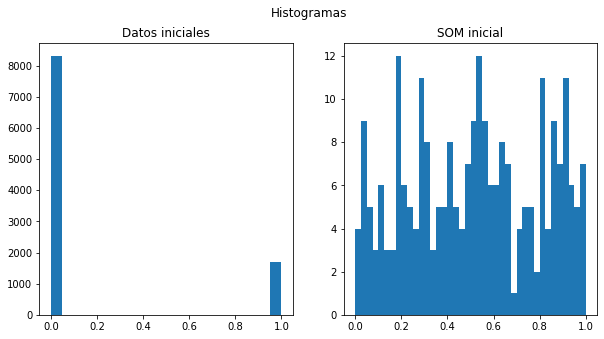

In [21]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
allDataVector = datosIniciales.to_numpy().ravel()
ax[0].hist(allDataVector,bins=20,range=[0,1])
ax[0].set_title('Datos iniciales')
allWVector = Wdf.to_numpy().ravel()
ax[1].hist(allWVector,bins=40,range=[0,1])
ax[1].set_title('SOM inicial')
f.suptitle('Histogramas')
plt.show()

In [22]:
allWVector[:5]

array([0.92314985, 0.52882086, 0.73288697, 0.59186186, 0.48537051])

Histograma por _feature_/atributo

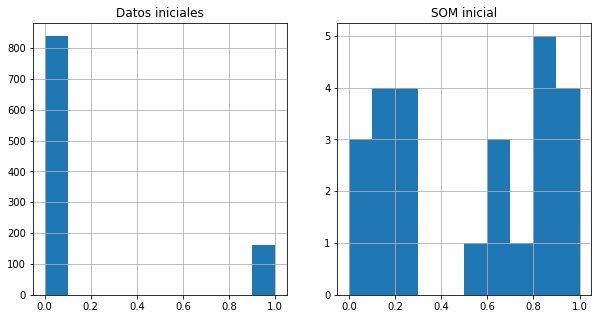

Feature:  2


In [23]:
feature = np.random.choice(nd)
datosInicialesFeature = datosIniciales.loc[:,feature]
datosNeuronaFeature = Wdf.loc[:,feature]
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
datosInicialesFeature.hist(ax=ax[0],range=[0,1])
datosNeuronaFeature.hist(ax=ax[1],range=[0,1])
ax[0].set_title('Datos iniciales')
ax[1].set_title('SOM inicial')
plt.show()
print('Feature: ',feature)

Histograma de dato/neurona individual

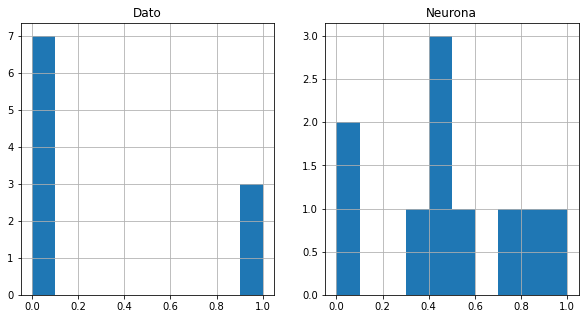

Dato: 344
Neurona: 18


In [24]:
neurona = np.random.choice(neu)
dato = np.random.choice(ni)
datosInicialesDato = datosIniciales.loc[dato,:]
datosNeurona = Wdf.loc[neurona,:]
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
datosInicialesDato.hist(ax=ax[0],range=[0,1])
datosNeurona.hist(ax=ax[1],range=[0,1])
ax[0].set_title('Dato')
ax[1].set_title('Neurona')
plt.show()
print('Dato: {}\nNeurona: {}'.format(dato,neurona))

### Medias y varianzas de las neuronas

Text(0.5, 1.0, 'Por neurona')

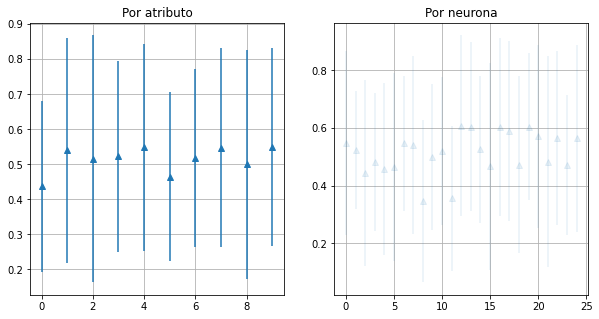

In [25]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
x=np.arange(nd)
ax[0].errorbar(x,Wdf.mean(),Wdf.std(),linestyle='None', marker='^')
ax[0].grid()
x = np.arange(neu)
ax[1].errorbar(x,Wdf.mean(axis=1),Wdf.std(axis=1),linestyle='None', marker='^',alpha=0.1)
ax[1].grid()
ax[0].set_title('Por atributo')
ax[1].set_title('Por neurona')

_Stacked barplot_ de las neuronas del SOM en su estado inicial

<AxesSubplot:>

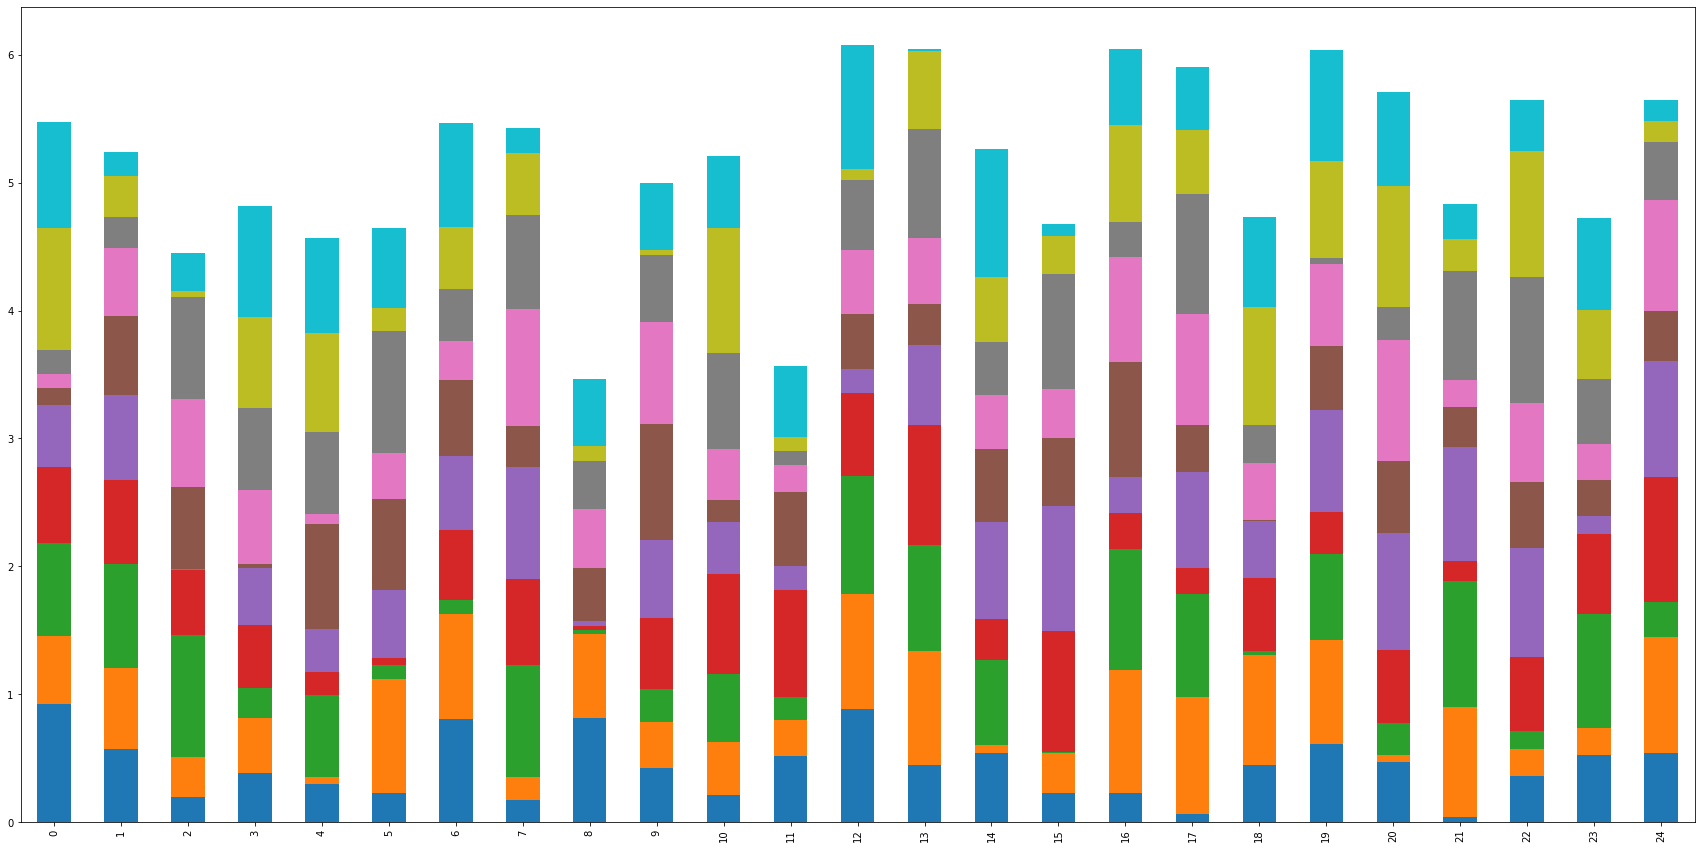

In [26]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(30,15))
Wdf.plot.bar(stacked=True,ax=ax,legend=False)

## _Funciones de núcleo de entorno_

En la actualización de los vectores de referencia de las neuronas se utiliza un núcleo de entorno (_neighborhood kernel_), $h_{ci}$, que modifica el entorno de vectores cercanos a la __BMU__. En este núcleo aparecen las funciones de la tasa de aprendizaje $\alpha$ y de varianza $\sigma$. Una sencilla elección es la siguiente:

$$
\alpha(k)=\frac{1}{1+k}\qquad \sigma(k)=-e^{-0.3k}
$$

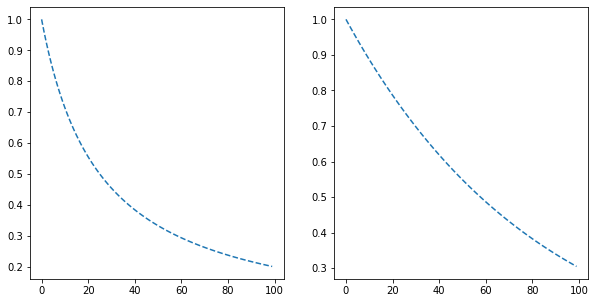

In [27]:
# graficamos las elecciones
kk = np.arange(0,100)
def alpha(k):
    s = k/(neu)
    return 1/(1+s)
def sigma(k):
    s=k/neu
    return np.exp(-0.3*s)
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot(kk,alpha(kk),'--',label=r'$\alpha(k)$')
ax[1].plot(kk,sigma(kk),'--',label=r'$\sigma(k)$')

## _Elección de la __Best Matching Unit__(BMU) y Actualización_

Para cada instancia que se presenta al SOM se elige una neurona cuyo vector de referencia cumpla una condición de mínimo, en concreto, de mínima distancia euclídea. Una vez hecha esta elección, los vectores de referencia se van actualizando a medida que las instancias son procesadas por la red auto-organizativa. 

Esta actualización se lleva a cabo mediante la fórmula de Kohonen con un núcleo de entorno exponencial.

In [28]:
def BMU(dato,SOM):
    distancias = []
    for ii in np.arange(neu):
        neurona = SOM.loc[ii].to_numpy()
        dist = np.sqrt(np.sum(((dato-neurona)**2)))
        distancias.append(dist)
    # seleccionamos la menor
    
    menorPosicion = np.argmin(np.asarray(distancias))
    return menorPosicion

def actualizarPesos(dato,SOM,posicionBMU,itt):
    '''
    itt: iteracion
    '''
    Vk = []
    for k in np.arange(neu):
        kernel = np.exp(-((posicionBMU-k)**2)/(2*sigma(i)**2))
        SOM.loc[k] = SOM.loc[k]+alpha(itt)*kernel*(dato-SOM.loc[k])
        Vk.append(np.sqrt(np.sum((SOM.loc[posicionBMU]-SOM.loc[k])**2)))
    Vmeanitt = np.mean(Vk)
    return SOM,Vmeanitt

def crearSOM():
    W = np.random.uniform(low=0.0,high=1.0,size=(neu,nd))
    Wdf = pd.DataFrame(W)
    return Wdf

In [46]:
#neu = 25
#ni = 1000
#nd = 10

Vm = []
Tm = []
Tvar = []
Bm = []
Bvar = []
closesdist = []

SOM = crearSOM()
SOMinit = SOM.copy()
for ii in np.arange(ni):
    if ii%100==0:
        print('Etapa:',ii)
    dato = datosIniciales.loc[ii].to_numpy()
    posicionBMU = BMU(dato,SOM)
    cd = np.sqrt(np.sum((dato-SOM.loc[posicionBMU])**2))
    closesdist.append(cd)
    #print(ii,posicionBMU)
    SOM,Vmeanitt = actualizarPesos(dato,SOM,posicionBMU,ii)
    Vm.append(Vmeanitt)
    Tm.append(SOM.to_numpy().ravel().mean())
    Tvar.append(SOM.to_numpy().ravel().std())
    Bm.append(SOM.loc[posicionBMU].to_numpy().mean())
    Bvar.append(SOM.loc[posicionBMU].to_numpy().std())
print('Finished')

Etapa: 0
Etapa: 100
Etapa: 200
Etapa: 300
Etapa: 400
Etapa: 500
Etapa: 600
Etapa: 700
Etapa: 800
Etapa: 900
Finished


Comparación de _barplots_

<AxesSubplot:>

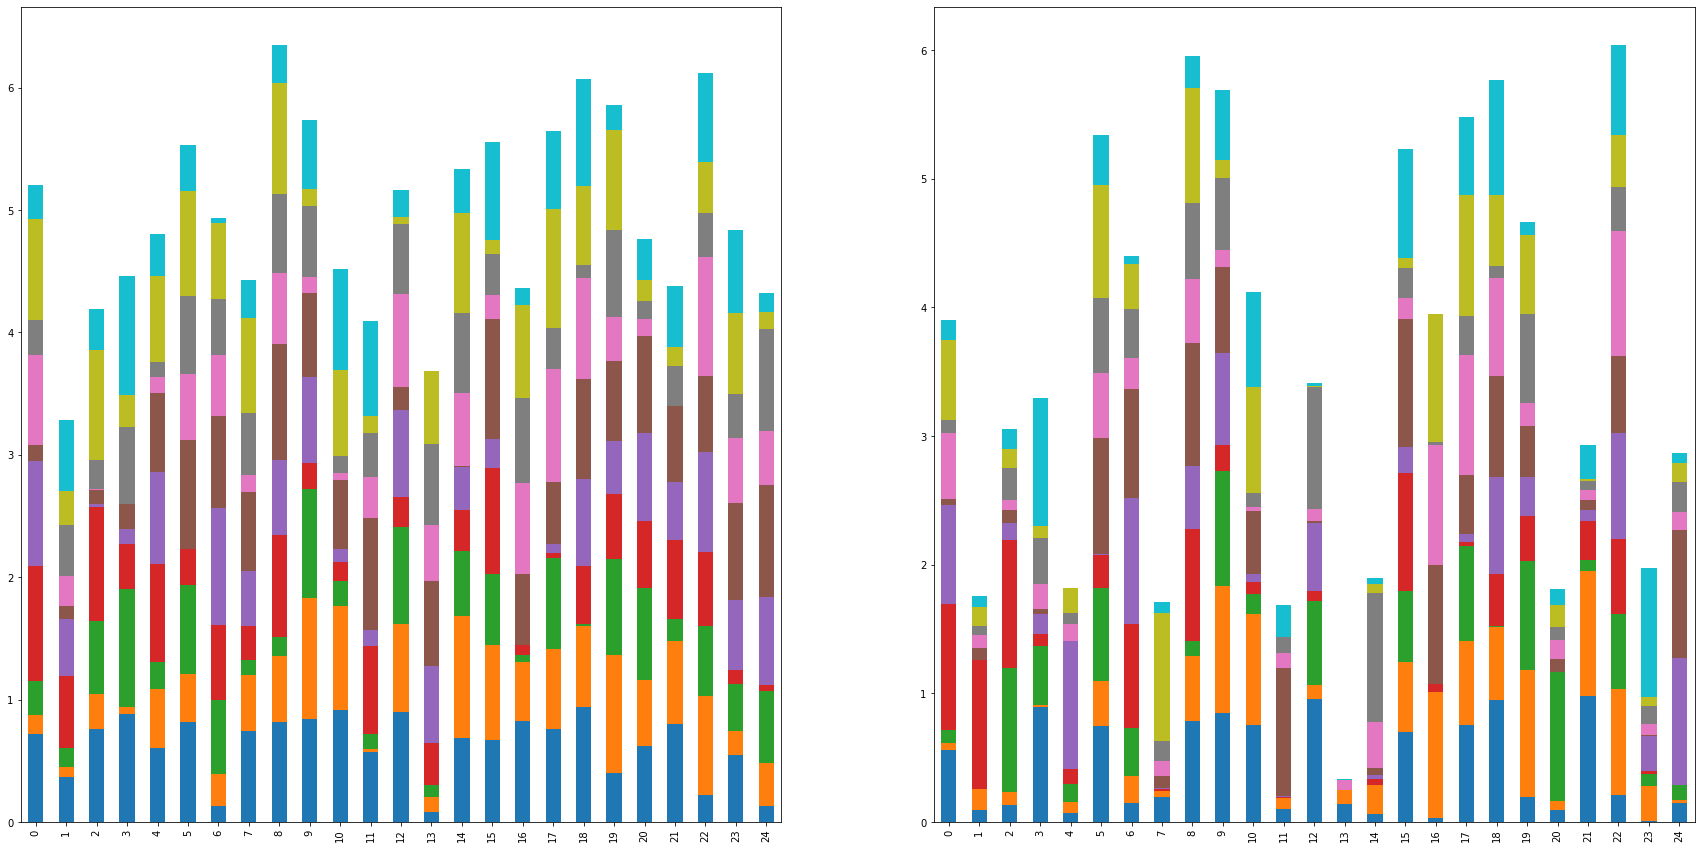

In [47]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(30,15))
SOMinit.plot.bar(stacked=True,ax=ax[0],legend=False)
SOM.plot.bar(stacked=True,ax=ax[1],legend=False)

Comparación de histogramas

[]

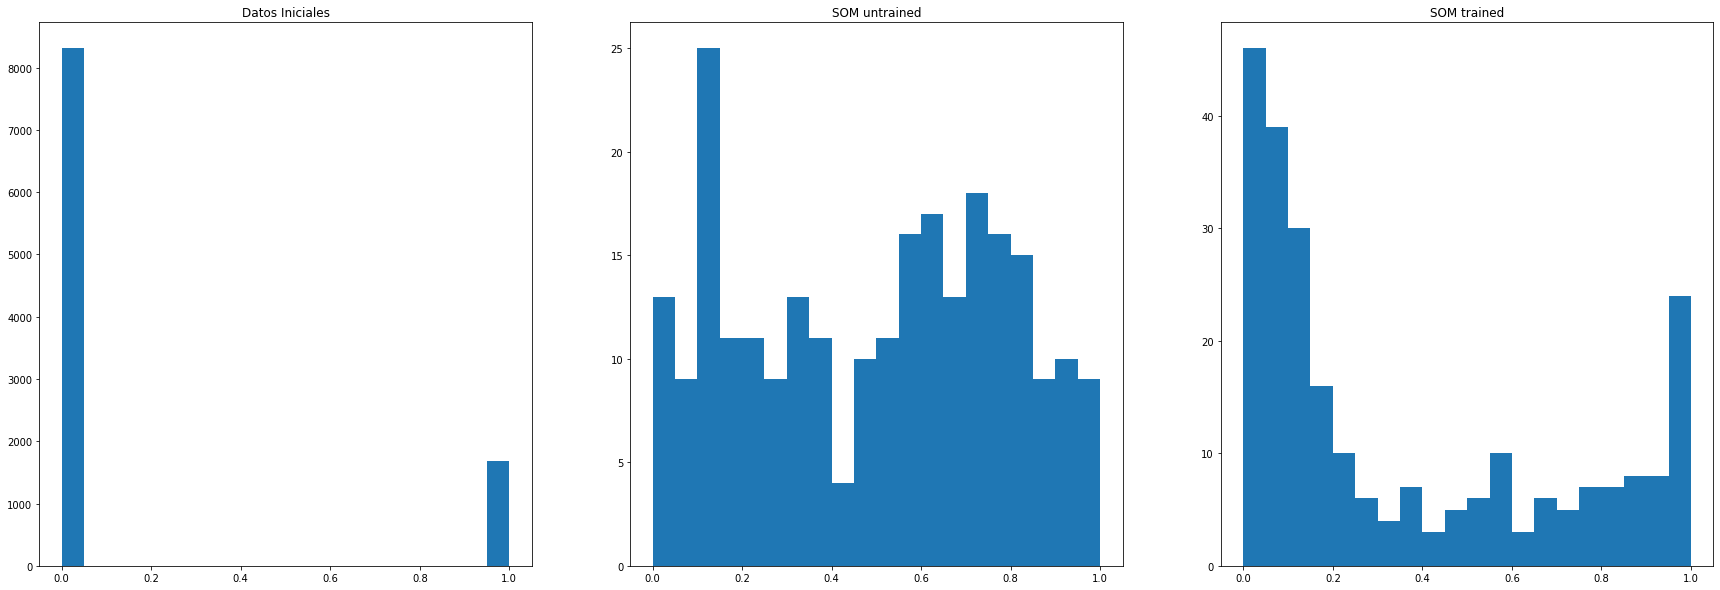

In [48]:
f,ax=plt.subplots(nrows=1,ncols=3,figsize=(30,10))
ax[0].hist(datosIniciales.to_numpy().ravel(),range=[0,1],bins=20)
ax[0].set_title('Datos Iniciales')
ax[1].hist(SOMinit.to_numpy().ravel(),range=[0,1],bins=20)
ax[1].set_title('SOM untrained')
ax[2].hist(SOM.to_numpy().ravel(),range=[0,1],bins=20)
ax[2].set_title('SOM trained')
plt.plot()


Histogramas de un feature

[]

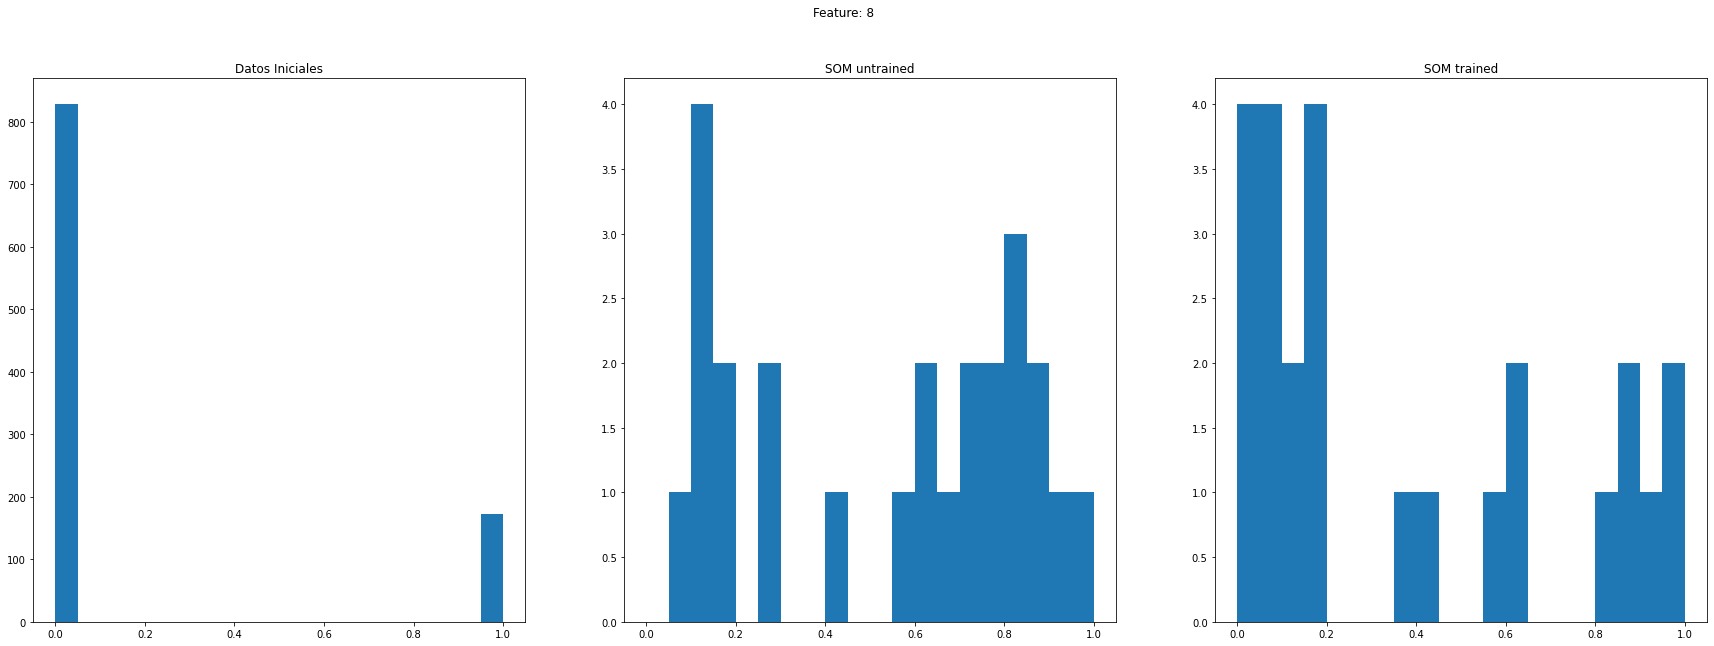

In [49]:
feature  = np.random.choice(nd)
f,ax=plt.subplots(nrows=1,ncols=3,figsize=(30,10))
ax[0].hist(datosIniciales.loc[:,feature].to_numpy().ravel(),range=[0,1],bins=20)
ax[0].set_title('Datos Iniciales')
ax[1].hist(SOMinit.loc[:,feature].to_numpy().ravel(),range=[0,1],bins=20)
ax[1].set_title('SOM untrained')
ax[2].hist(SOM.loc[:,feature].to_numpy().ravel(),range=[0,1],bins=20)
ax[2].set_title('SOM trained')
f.suptitle('Feature: {}'.format(feature))
plt.plot()


Text(0.5, 1.0, 'Por neurona')

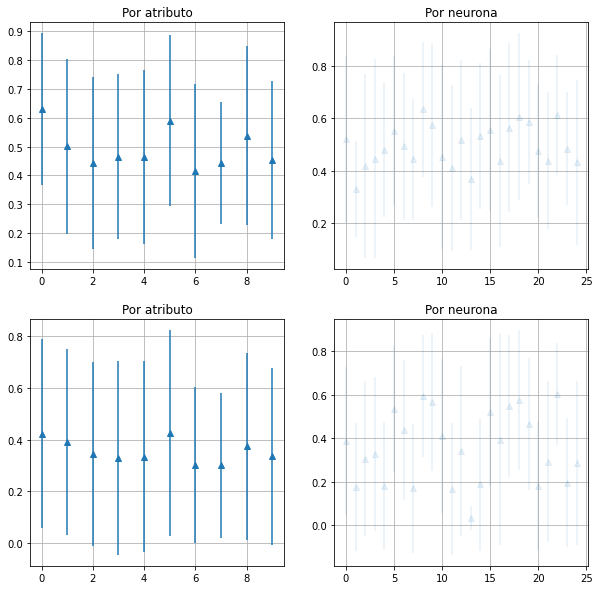

In [54]:
f,ax=plt.subplots(nrows=2,ncols=2,figsize=(10,10))
x=np.arange(nd)
ax[0,0].errorbar(x,SOMinit.mean(),SOMinit.std(),linestyle='None', marker='^')
ax[0,0].grid()
ax[0,0].set_title('Por atributo')
ax[1,0].errorbar(x,SOM.mean(),SOM.std(),linestyle='None', marker='^')
ax[1,0].grid()
ax[1,0].set_title('Por atributo')

x = np.arange(neu)
ax[0,1].errorbar(x,SOMinit.mean(axis=1),SOMinit.std(axis=1),linestyle='None', marker='^',alpha=0.1)
ax[0,1].grid()
ax[0,1].set_title('Por neurona')
ax[1,1].errorbar(x,SOM.mean(axis=1),SOM.std(axis=1),linestyle='None', marker='^',alpha=0.1)
ax[1,1].grid()
ax[1,1].set_title('Por neurona')

### Asociar datos a neuronas

In [50]:
BMUV = []
for ii in range(ni):
    dato = datosIniciales.loc[ii]
    posicionBMU = BMU(dato,SOM)
    BMUV.append(posicionBMU)

Text(0, 0.5, 'Neurona BMU')

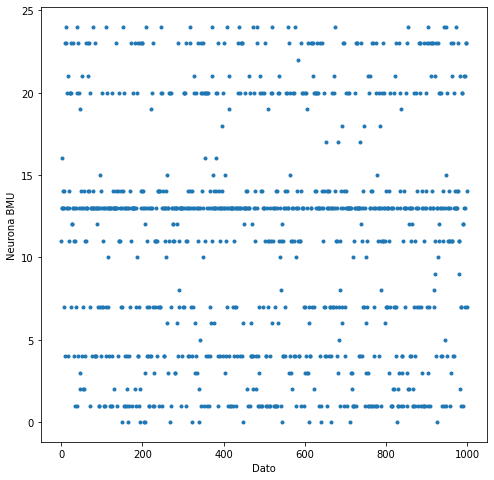

In [51]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
plt.plot(range(ni),BMUV,'.')
plt.xlabel('Dato')
plt.ylabel('Neurona BMU')

### Gráficas de evolucion

In [64]:
datosIniciales.to_numpy().ravel().mean(),datosIniciales.to_numpy().ravel().std()

(0.1688, 0.374575172695682)

Text(0.5, 1.0, 'closesdist')

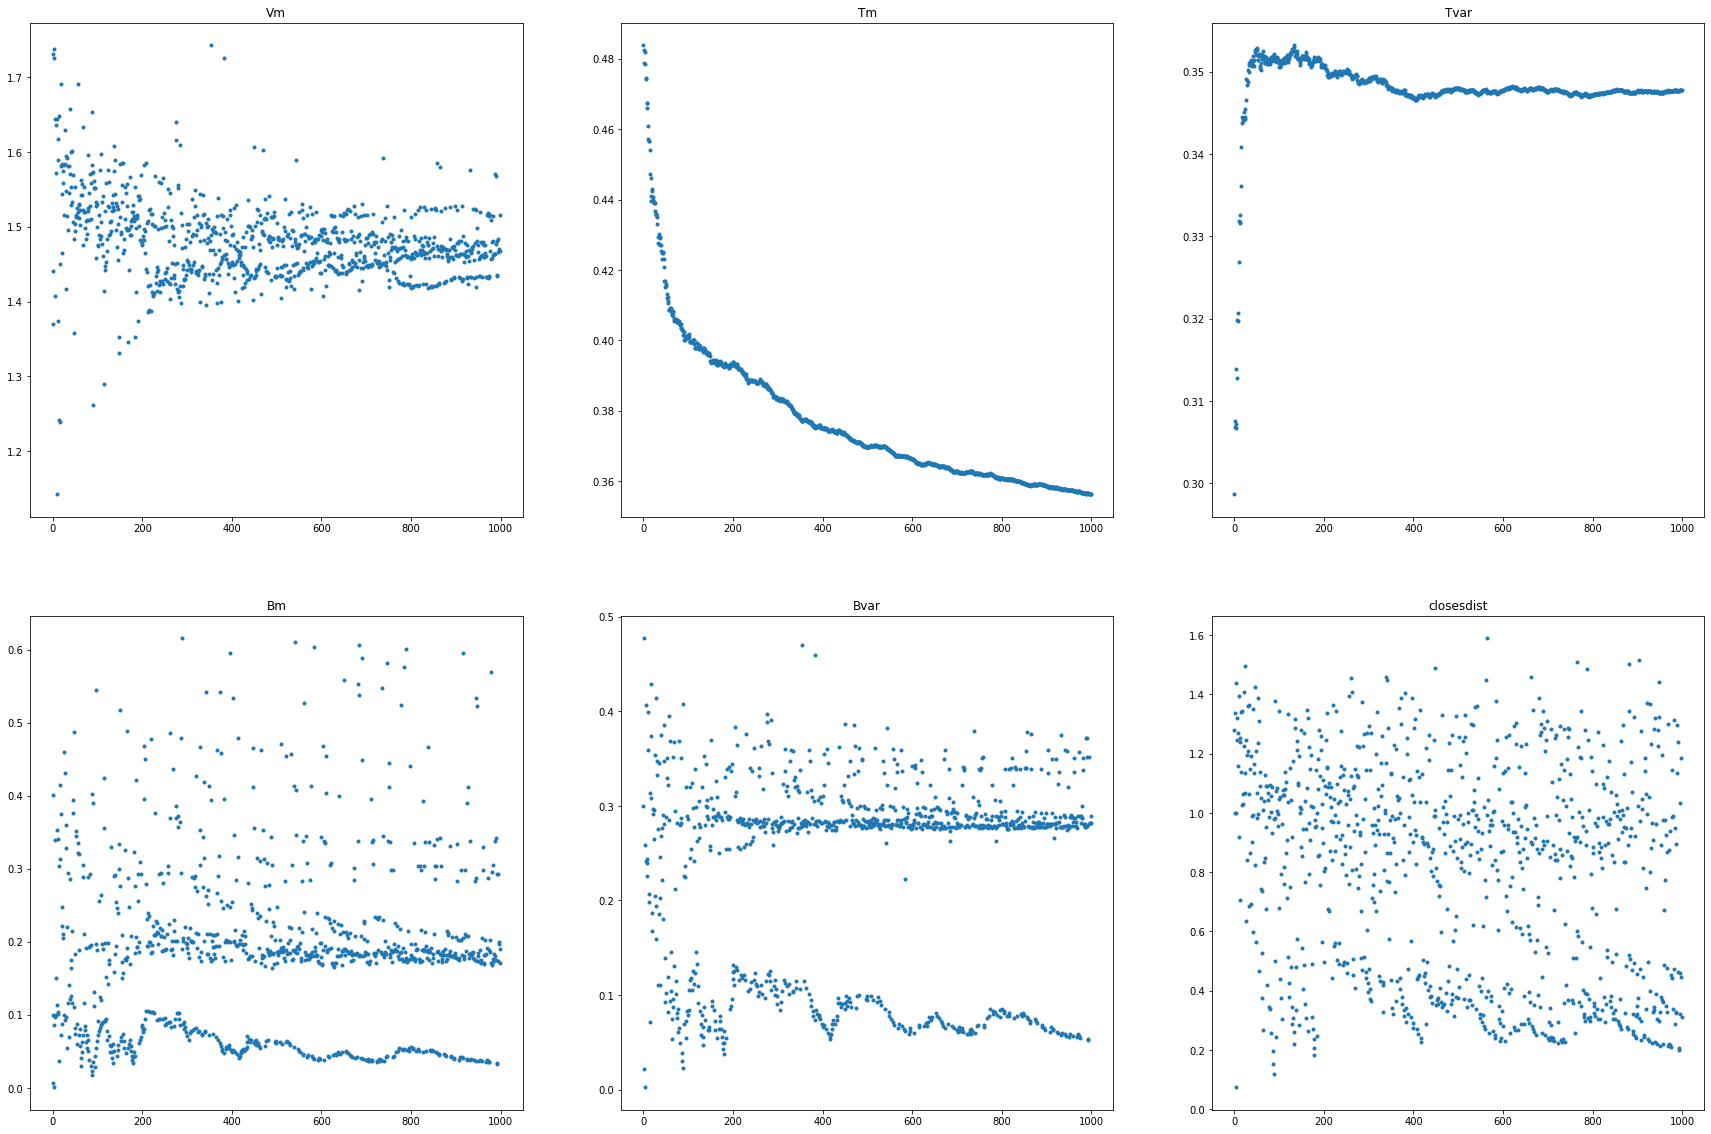

In [61]:
xx = np.arange(ni)
f,axes=plt.subplots(nrows=2,ncols=3,figsize=(30,20))
ax=axes.ravel()
ax[0].plot(xx,Vm,'.')
ax[0].set_title('Vm')
ax[1].plot(xx,Tm,'.')
ax[1].set_title('Tm')
ax[2].plot(xx,Tvar,'.')
ax[2].set_title('Tvar')
ax[3].plot(xx,Bm,'.')
ax[3].set_title('Bm')
ax[4].plot(xx,Bvar,'.')
ax[4].set_title('Bvar')
ax[5].plot(xx,closesdist,'.')
ax[5].set_title('closesdist')

## Ejercicios

* Realiza un entrenamiento SOM con varias _épocas_ de aprendizaje
* Aleatoriza la entrada de los datos al proceso de aprendizaje
* Varía los parámetros de aprendizaje
* Compara los resultados
* Comenta las gráficas